In [1]:
!pip install torch
!pip install matplotlib
!pip install torchvision

You should consider upgrading via the 'c:\users\adam\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\adam\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\adam\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision 
import torchvision.transforms as T 
from PIL import Image
import random
img_dir = "C:/Users/Adam/Downloads/UF_Spring_2022/Deep_Learning/Proj2/face_images/"
torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
data = load_images_from_folder(img_dir)

In [5]:
print(data[0].shape) #each images is 128 by 128 pixels and in rgb thus the 3 for color values
print(len(data)) #number of images in dataset
print(type(data))
print(type(data[0]))

(128, 128, 3)
750
<class 'list'>
<class 'numpy.ndarray'>


In [6]:
data = np.asarray(data)
print(data.shape)

(750, 128, 128, 3)


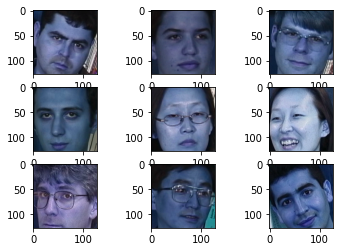

In [7]:
for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i][:,:,:])

Now we will convert how the images are stored and augment them to get more data 

In [8]:
data = torch.from_numpy(data) #converts numpy matrix to tensor
data = torch.movedim(data, 3, 1) #moves the rgb to the second index
data = data[torch.randperm(data.size()[0])]#randomly shuffles tensor along first dim 

In [9]:
print(data.shape)
print(type(data))

torch.Size([750, 3, 128, 128])
<class 'torch.Tensor'>


In [10]:
#helper function to print pytorch tensor 
#input is a single tensor
def print_tensor_to_numpy(tensor):
    tensor_reshape = torch.movedim(tensor, 0, 2)
    npimg = tensor_reshape.numpy()
    plt.imshow(npimg[:, :, :])   

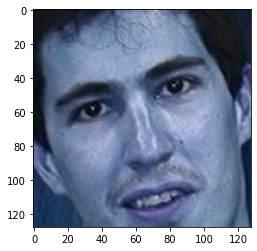

In [11]:
print_tensor_to_numpy(data[5, :,:,:])

Augment Dataset

In [12]:
print(data.shape)
print(type(data))

torch.Size([750, 3, 128, 128])
<class 'torch.Tensor'>


In [13]:
#flips the image, takes a single image and shows result if show is set to True
def flip_img(tensor, show =False):
    flipped_img = torch.flip(tensor, (2,))
    if show == True:
        print_tensor_to_numpy(flipped_img)
    return flipped_img

tensor([[[ 19,  14,  22,  ...,  17,  16,  18],
         [ 19,  13,  21,  ...,  18,  19,  21],
         [ 19,  15,  19,  ...,  21,  24,  24],
         ...,
         [ 18,  63,  89,  ...,  23,  26,  25],
         [ 24,  67,  88,  ...,  21,  28,  29],
         [ 35,  75,  88,  ...,  21,  35,  32]],

        [[ 33,  28,  36,  ...,  16,  15,  17],
         [ 33,  26,  34,  ...,  17,  18,  20],
         [ 31,  27,  31,  ...,  20,  21,  21],
         ...,
         [ 42,  87, 113,  ...,  52,  55,  54],
         [ 48,  91, 112,  ...,  50,  55,  56],
         [ 59,  99, 112,  ...,  50,  62,  59]],

        [[ 55,  50,  55,  ...,  20,  17,  19],
         [ 55,  48,  56,  ...,  21,  20,  22],
         [ 55,  51,  55,  ...,  22,  23,  23],
         ...,
         [ 72, 117, 143,  ...,  89,  94,  93],
         [ 78, 121, 142,  ...,  87,  92,  93],
         [ 89, 129, 142,  ...,  87,  99,  96]]], dtype=torch.uint8)

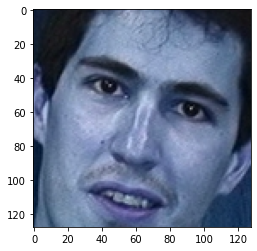

In [14]:
flip_img(data[5, :, :, :], True)

In [15]:
#crops image takes a single image tensor and crops it, shows image if show is set to true
def crop_img(tensor, show = False):
    crop = T.RandomCrop((96,96)) # transform for square crop
    resize_crop = T.Resize((128,128)) #resizes image back to original dimension
    cropped_img = resize_crop(crop(tensor)) 
    if show == True:
        print_tensor_to_numpy(cropped_img)
    return cropped_img

tensor([[[107, 109, 111,  ...,  21,  23,  24],
         [111, 114, 116,  ...,  20,  22,  23],
         [115, 118, 121,  ...,  19,  21,  21],
         ...,
         [ 91,  90,  87,  ...,  76,  45,  13],
         [ 89,  88,  85,  ...,  79,  46,  12],
         [ 81,  83,  83,  ...,  80,  46,   9]],

        [[123, 127, 129,  ...,  31,  35,  37],
         [129, 133, 135,  ...,  30,  34,  36],
         [134, 137, 140,  ...,  29,  33,  34],
         ...,
         [110, 110, 107,  ...,  97,  67,  35],
         [108, 107, 105,  ..., 100,  68,  34],
         [101, 102, 103,  ..., 102,  68,  31]],

        [[159, 162, 165,  ...,  45,  50,  53],
         [165, 168, 170,  ...,  44,  49,  52],
         [169, 172, 176,  ...,  43,  48,  50],
         ...,
         [143, 142, 140,  ..., 126,  95,  63],
         [141, 140, 138,  ..., 129,  96,  62],
         [132, 134, 136,  ..., 131,  96,  59]]], dtype=torch.uint8)

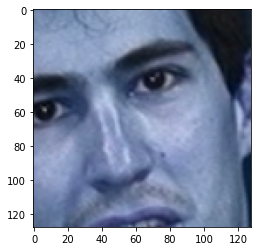

In [16]:
crop_img(data[5, :, :, :], True)

In [17]:
def tint_img(tensor, show = False):
    tint_val = 0.1*random.randrange(6, 10)
    tensor[0, :, :] = tint_val*tensor[0, :, :]
    tensor[1, :, :] = tint_val*tensor[1, :, :]
    tensor[2, :, :] = tint_val*tensor[2, :, :]
    tinted_img = tensor[:, :, :]
    if show == True:
        print_tensor_to_numpy(tinted_img)
    return tinted_img

tensor([[[ 12,  11,  11,  ...,  15,   9,  13],
         [ 14,  13,  12,  ...,  14,   9,  13],
         [ 16,  16,  14,  ...,  13,  10,  13],
         ...,
         [ 17,  18,  16,  ...,  62,  44,  12],
         [ 20,  19,  14,  ...,  61,  46,  16],
         [ 22,  24,  14,  ...,  61,  52,  24]],

        [[ 11,  10,  11,  ...,  25,  19,  23],
         [ 14,  12,  11,  ...,  23,  18,  23],
         [ 14,  14,  14,  ...,  21,  18,  21],
         ...,
         [ 37,  38,  36,  ...,  79,  60,  29],
         [ 39,  38,  35,  ...,  78,  63,  33],
         [ 41,  43,  35,  ...,  78,  69,  41]],

        [[ 13,  11,  14,  ...,  38,  35,  38],
         [ 15,  14,  14,  ...,  39,  33,  38],
         [ 16,  16,  15,  ...,  38,  35,  38],
         ...,
         [ 65,  65,  62,  ..., 100,  81,  50],
         [ 65,  64,  60,  ...,  99,  84,  54],
         [ 67,  69,  60,  ...,  99,  90,  62]]], dtype=torch.uint8)

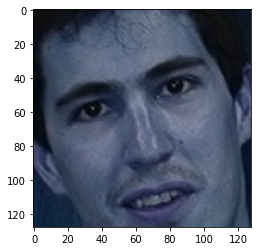

In [18]:
tint_img(data[5, :, :,:], True)

In [19]:
########################

#its not really specified how the new data should be made for example should we flip all of the images, 750+750
#and then crop the original images 3 times an image to make another 3*750 images
#and then tint the original images 0.6-1 thus producing 4*750
#or if we should just apply some random combination of all of the transforms and use that to create the new images


######################
#weird combination of all the transforms
def create_new_img(tensor):
    chance = random.randrange(1, 10)
    #60% chance of only one transformation
    if (chance < 2):
        new_img = flip_img(tensor) 
    else if (chance >= 2 && chance <4):
        new_img = crop_img(tensor)
    else if (chance >= 4 && chance <6):
        new_img = tint_img(tensor)
    #40% chance of more complex transformations
    else if (chance >= 6 && chance <8):
        tensor_cropped = crop_img(tensor)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
    else if (chance >= 8 && chance <=10):
        tensor_flipped = flip_img(tensor) 
        tensor_cropped = crop_img(tensor_flipped)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted

    return new_img


In [ ]:
###for loop which appends the newly created images